# Partially coded field of view

In this notebook we attempt to integrate PCFOV in our simplistic simulation and to adapt our reconstruction methods to it.

## 1D masks recap

Let's go back to 1D masks and Hankel formulation of the cross-correlation reconstruction. Consider this simple padded 1D URA pattern:

In [1]:
import numpy as np


ura_cycle = np.array([1,1,1,0,1,0,0])
ura_mask = np.concatenate((ura_cycle[-3:], ura_cycle, ura_cycle[:3]))
decoding_mask = np.copy(ura_mask)
decoding_mask[ura_mask == 0] = -1

print(f"mask pattern: {ura_mask}\ndecoder pattern:{decoding_mask}")

mask pattern: [1 0 0 1 1 1 0 1 0 0 1 1 1]
decoder pattern:[ 1 -1 -1  1  1  1 -1  1 -1 -1  1  1  1]


The Hankel matrix a matrix composed by the 1-shifted whole pattern mask cycles:

In [2]:
from scipy.linalg import hankel

hankel_ura_mask = hankel(ura_mask[:len(ura_cycle)], ura_mask[len(ura_cycle) - 1:])
hankel_ura_mask

array([[1, 0, 0, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 0, 1],
       [0, 1, 1, 1, 0, 1, 0],
       [1, 1, 1, 0, 1, 0, 0],
       [1, 1, 0, 1, 0, 0, 1],
       [1, 0, 1, 0, 0, 1, 1],
       [0, 1, 0, 0, 1, 1, 1]])

The dot product of the mask Hankel matrix and of the decoded Hankel matrix is diagonal or, equivalently, the PSF is diagonal.

In [3]:
hankel_decoding = hankel(decoding_mask[:len(ura_cycle)], decoding_mask[len(ura_cycle) - 1:])
np.dot(hankel_ura_mask, hankel_decoding)

array([[4, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 0, 0],
       [0, 0, 4, 0, 0, 0, 0],
       [0, 0, 0, 4, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0],
       [0, 0, 0, 0, 0, 4, 0],
       [0, 0, 0, 0, 0, 0, 4]])

The detector image is formed by the dot product of the Hankel mask and the source.

In [4]:
source = np.array([0, 0, 0, 1, 0, 0, 0])
detector = hankel_ura_mask.dot(source)
detector

array([1, 1, 1, 0, 1, 0, 0])

Similiarly, the cross-correlated source image (multiplied by a constant) is the dot product of the Hankel decoded and the detector:

In [5]:
source = hankel_decoding.dot(detector)
source

array([0, 0, 0, 4, 0, 0, 0])

## 1D masks - adding the PCFOV

To include the PCFOV in our discussion, we pad the mask with a number of zeros equal to the length of the ura cycle minus one, on both sides.

In [6]:
zero_padding = np.zeros((len(ura_cycle) - 1))
left_padding = ura_cycle[-(len(ura_cycle) // 2):] # the parenthesis are crucial here
right_padding = ura_cycle[:len(ura_cycle) // 2]

pcfov_mask = np.concatenate((zero_padding, left_padding, ura_cycle, right_padding, zero_padding))
pcfov_mask

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0.])

What a drama, these are going to be large! So let's make a recap, we have:
1. 25 mask elements
2. 19 solvable sky direction
3. 7 detector elements
We are going to reconstruct a detector image (shape 7x1) by taking the dot product of a Hankel matrix and a source vector (19x1). This implies that the Hankel matrix should have dimension 7x19! To build the hankel matrix with scipy, we pass the first column and the last row.

In [7]:
hankel_pcfov_mask = hankel(
    pcfov_mask[:len(ura_cycle)],  # first column
    pcfov_mask[-(len(pcfov_mask) - (len(ura_cycle) - 1)):],  # last row
)
hankel_pcfov_mask

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0.,
        1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1.,
        1., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
        1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1.,
        0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0.,
        0., 0., 0.],
       [0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0.],
       [1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
        0., 0., 0.]])

Let's try to apply to the same source above.

In [8]:
source = np.concat((zero_padding, np.array([0, 1, 0, 1, 0, 0, 0]), zero_padding))
detector = hankel_pcfov_mask.dot(source)
detector

array([1., 1., 2., 1., 2., 0., 1.])

We get the same detector image! Yuhu!

Let's try with the "leftmost" source in the PCFOV.

In [9]:
source = np.zeros(19)
source[0] = 1
detector = hankel_pcfov_mask.dot(source)
detector

array([0., 0., 0., 0., 0., 0., 1.])

Understandably, the only detector element affected is the leftmost one.

Now the source image from the detector. My understanding is that the decoder should be modified to have zero padding on its border, exactly as we do with the mask.

In [10]:
decoder_cycle = ura_cycle.copy()
decoder_cycle[decoder_cycle == 0] = -1

zero_padding = np.zeros((len(ura_cycle) - 1))
left_padding = decoder_cycle[-(len(ura_cycle) // 2):] # the parenthesis are crucial here
right_padding = decoder_cycle[:len(ura_cycle) // 2]

pcfov_decoder = np.concatenate((zero_padding, left_padding, decoder_cycle, right_padding, zero_padding))
pcfov_decoder

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1., -1., -1.,  1.,  1.,  1., -1.,
        1., -1., -1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])

Now to build the hankel matrix we should be careful: the shape of the hankel decoder should be equal to the shape of the transpose of the hankel mask. In our case this means that we need a 19x7 hankel decoder.

In [11]:
hankel_pcfov_decoder = hankel(
    pcfov_decoder[:len(pcfov_mask) - (len(ura_cycle) - 1)],  # first column
    pcfov_decoder[:-(len(pcfov_mask) - (len(ura_cycle)))],  # last row
)

In [12]:
hankel_pcfov_decoder

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -1.],
       [ 0.,  0.,  0.,  0.,  1., -1., -1.],
       [ 0.,  0.,  0.,  1., -1., -1.,  1.],
       [ 0.,  0.,  1., -1., -1.,  1.,  1.],
       [ 0.,  1., -1., -1.,  1.,  1.,  1.],
       [ 1., -1., -1.,  1.,  1.,  1., -1.],
       [-1., -1.,  1.,  1.,  1., -1.,  1.],
       [-1.,  1.,  1.,  1., -1.,  1., -1.],
       [ 1.,  1.,  1., -1.,  1., -1., -1.],
       [ 1.,  1., -1.,  1., -1., -1.,  1.],
       [ 1., -1.,  1., -1., -1.,  1.,  1.],
       [-1.,  1., -1., -1.,  1.,  1.,  1.],
       [ 1., -1., -1.,  1.,  1.,  1.,  0.],
       [-1., -1.,  1.,  1.,  1.,  0.,  0.],
       [-1.,  1.,  1.,  1.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  1.]])

Let's test this first with a source in the FCFOV

In [44]:
source = np.zeros(len(pcfov_mask) - len(ura_cycle) + 1)

source[7] = 1 # defining the source location

detector = hankel_pcfov_mask.dot(source)
detector

array([0., 0., 1., 1., 1., 0., 1.])

In [45]:
source = hankel_pcfov_decoder.dot(np.c_[detector])
source.T

array([[ 1., -1.,  0.,  1.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,
         1.,  3.,  2.,  1.,  0.,  1.]])

Fantastic, here its! We can see the coding noise over the PCFOV part of the source sky, and the source in the fully-coded part of the sky.
Let's try to see what happens with sources in the PCFOV.



In [46]:
source = np.zeros(len(pcfov_mask) - len(ura_cycle) + 1)
source[2] = 1
detector = hankel_pcfov_mask.dot(source)
source = hankel_pcfov_decoder.dot(np.c_[detector])
source.T

array([[ 0.,  0.,  1., -1., -1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1.,
         1.,  1.,  0.,  0.,  0.,  0.]])

Look, we got the source in its right place, with ghosts of equal intensity in FCFOV!

## From dot product to correlation

Now that we know how to actually understand the matrices let's pass to the cross-correlation formalism with 1D signals. We generate a source in the FCFOV.

In [87]:
source = np.zeros(len(pcfov_mask) - len(ura_cycle) + 1)

source[9] = 10 # defining the source location

The detector using Hankel matrices:

In [88]:
detector = hankel_pcfov_mask.dot(source)
detector

array([10., 10., 10.,  0., 10.,  0.,  0.])

We should be able to get the same result with correlation:

In [89]:
from scipy.signal import correlate

n = len(source)
detector = correlate(pcfov_mask, source)[n-1: -n+1]
detector

array([10., 10., 10.,  0., 10.,  0.,  0.])

Here it is! For sky image reconstruction, this is what we get with Hankel matrices:

In [90]:
detector = hankel_pcfov_mask.dot(source)
source = hankel_pcfov_decoder.dot(np.c_[detector])
source.T

array([[  0.,   0.,  10., -10.,   0.,  10.,   0.,   0.,   0.,  40.,   0.,
          0.,   0.,   0.,   0.,  10.,  30.,  20.,  10.]])

With correlation:

In [91]:
n = len(detector)
source = correlate(pcfov_decoder, detector)[n-1:-n+1]
source

array([  0.,   0.,  10., -10.,   0.,  10.,   0.,   0.,   0.,  40.,   0.,
         0.,   0.,   0.,   0.,  10.,  30.,  20.,  10.])

Note the `n` definition changed!

In [92]:
np.sum(source)

np.float64(120.0)

## 2D masks - PCFOV

In [22]:
from masks import ura, pad
import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt

In [23]:
len_x, len_y = 61, 59
_mask, _decoder = ura(len_x, len_y)
_mask, _decoder = pad(_mask), pad(_decoder) # wrap fundamental tile with repetitions on borders
mask, decoder = map(lambda x: np.pad(
        x,
        pad_width = ((len_x - 1, len_x - 1), (len_y - 1, len_y - 1)),
        mode="constant",
    ), (_mask, _decoder)) # pads with zero

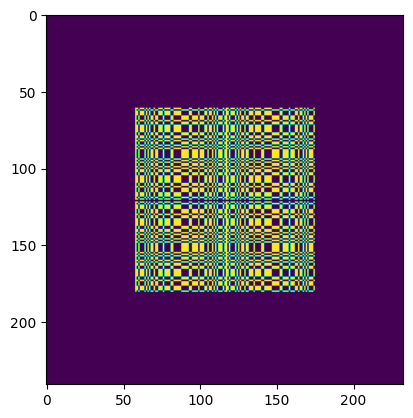

In [24]:
plt.imshow(mask)

In [29]:
len_x_, len_y_ = mask.shape
source = np.zeros((len_x_ - len_x + 1, len_y_ - len_y + 1))
source[100, 100] = 10

In [33]:
source.shape

(181, 175)

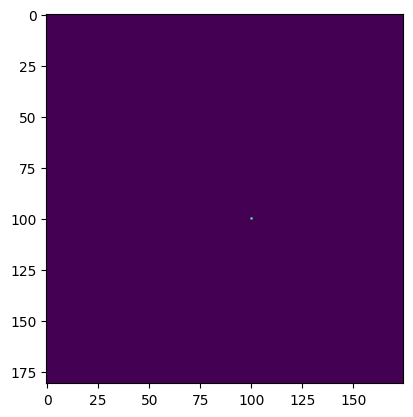

In [30]:
plt.imshow(source)

In [31]:
n, m = source.shape
detector = correlate(mask, source)[n - 1 : -n + 1, m - 1 : -m + 1]

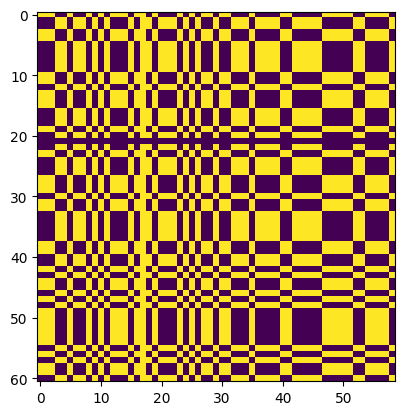

In [32]:
plt.imshow(detector)

# Balancing

The formula for balancing should be:

$$ S = G * D - G * P \frac{\sum{d_i}}{\sum{p_i}} $$

where:
1. $S$ is the sky-reconstructed image.
2. $P$ is the bulk array or sensitive array, an array of weights for the detector response.

Hence we have to compute the correction on the right-hand side.

In [110]:
source = np.zeros(len(pcfov_mask) - len(ura_cycle) + 1)

source[9] = 10 # defining the source location

n = len(source)
detector = correlate(pcfov_mask, source)[n-1: -n+1]
detector, source

(array([10., 10., 10.,  0., 10.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.]))

In [111]:
bulk = np.ones(detector.shape)

In [112]:
n = len(detector)
correction = correlate(pcfov_decoder, bulk)[n-1:-n+1] * np.sum(detector) / np.sum(bulk)

In [117]:
n = len(detector)
source = correlate(pcfov_decoder, detector)[n-1:-n+1]
source_balanced = source - correction

In [118]:
source_balanced

array([ -5.71428571,   0.        ,  15.71428571, -10.        ,
        -5.71428571,  -1.42857143,  -5.71428571,  -5.71428571,
        -5.71428571,  34.28571429,  -5.71428571,  -5.71428571,
        -5.71428571, -11.42857143,  -5.71428571,  -1.42857143,
        12.85714286,   8.57142857,   4.28571429])

In [119]:
import matplotlib.pyplot as plt

In [120]:
source

array([  0.,   0.,  10., -10.,   0.,  10.,   0.,   0.,   0.,  40.,   0.,
         0.,   0.,   0.,   0.,  10.,  30.,  20.,  10.])

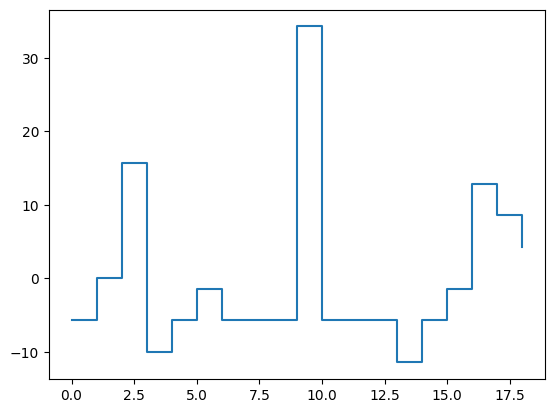

In [121]:
plt.step(np.arange(len(k := source_balanced)), k, where="post"); plt.show()

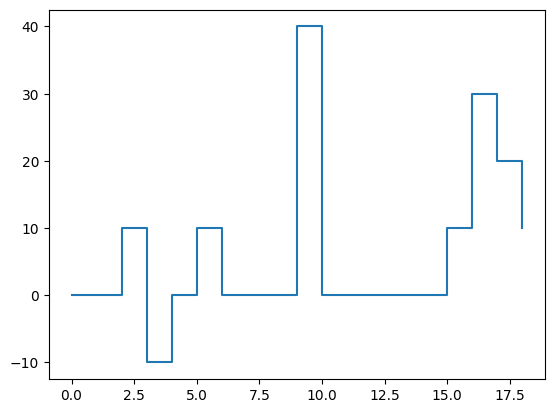

In [122]:
plt.step(np.arange(len(k := source)), k, where="post"); plt.show()

In [100]:
imgSum = detImage["image"].sum()
sensSum = arrObj["sens"].sum()
imgCorr = correlate(detImage["image"], arrObj["rmatrix"], mode="same", method="fft")
sensCorr = correlate(arrObj["sens"], arrObj["rmatrix"], mode="same", method="fft")
imgCorr2 = correlate(detImage["image"], arrObj["rmatrix"] ** 2, mode="same", method="fft")
### Counts
skyBal = imgCorr - sensCorr * imgSum / sensSum
### Variance
skyBalVar = imgCorr2 + imgSum * sensCorr**2 / sensSum**2 - 2 * imgCorr * sensCorr / sensSum
### Significance
skyBalSign = skyBal / np.sqrt(skyBalVar)
skyBalSign[np.isnan(skyBalSign)] = 0


detImage["image"] -> detector image
arrObj["rmatrix"] -> reconstruction matrix
arrObj["sens"] -> sensitive array o bulk array

SyntaxError: invalid syntax (3189479469.py, line 15)